# Regression Project2 - RDD


### Requirements: 

#### A - find data on * at least * one COVID measure for y:

either:

    1 - COVID cases
    2 - hospitalizations
    3 - deaths
#### B - Use RDD to estimate the effect of the following events in Quebec:

- D1. 20/3/2020 - lockdown

- D2. 31/8/2020 - The reopening of schools 

- D3. 25/12/2020 - lockdown

#### C - provide the following for each:

- c.1) A RDD plot similar to the ones shown above

- c.2) An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)

- c.3) A justification on the design of your regression:

       The amount of time included on both sides of the cutoff (longer is not necessarily better)

       The polynomial degree (higher is not always better)

       Other regression design considerations

- c.4) A 2 paragraph explanation of your findings for that event.

#### Data Sources:
    https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes
    https://www.inspq.qc.ca/covid-19/donnees

    https://www.inspq.qc.ca/sites/default/files/covid/donnees/covid19-hist.csv
    the columns explained  https://github.com/SimonCoulombe/covidtwitterbot
    
    https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&time=2020-03-01..latest&facet=none&pickerSort=asc&pickerMetric=location&Metric=Hospital+patients&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=~CAN
    https://health-infobase.canada.ca/covid-19/#a3
    https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.formula.api import ols
import pandas as pd
from patsy import dmatrices
import scipy.stats as sc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns 
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

import scipy.stats
import scipy.special

from sklearn.model_selection import train_test_split

sns.set()

####  DATAFRAMES

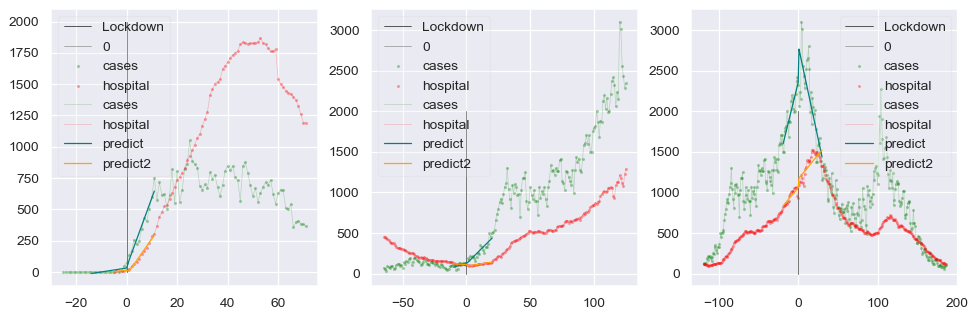

this is 0


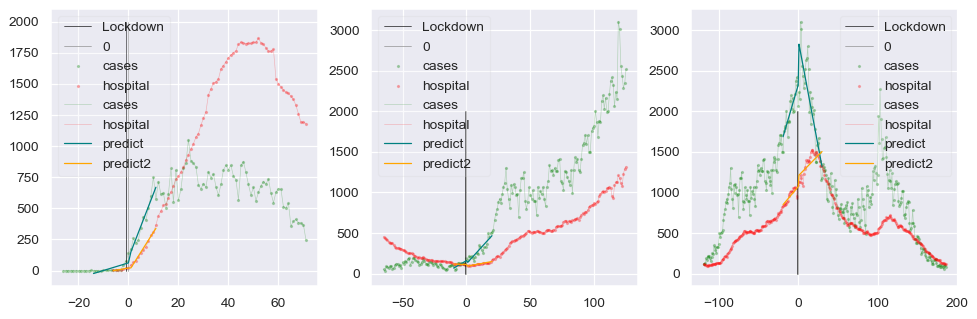

this is 1


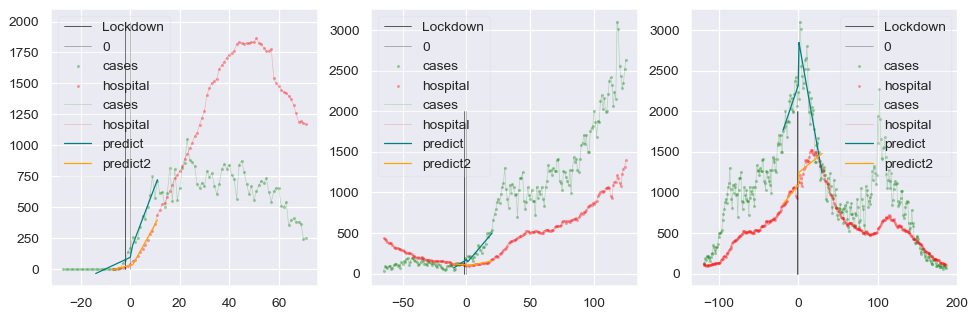

this is 2


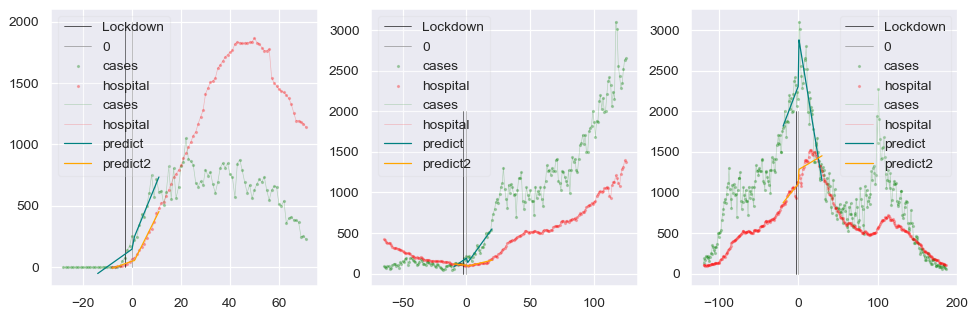

this is 3


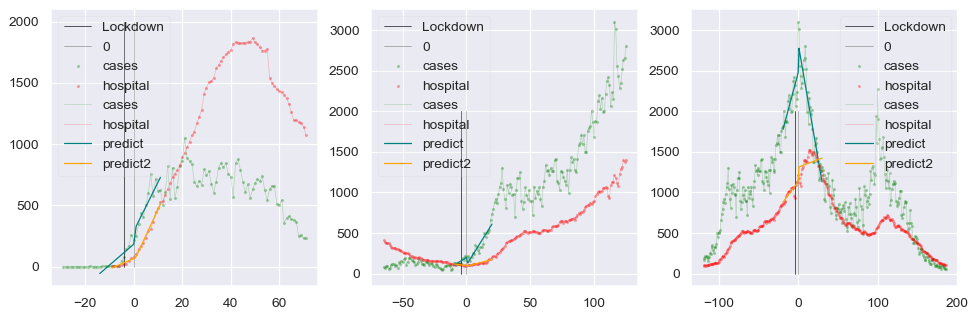

this is 4


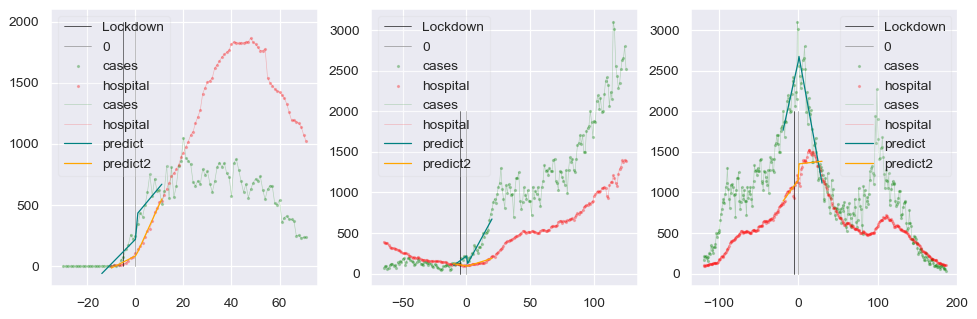

this is 5


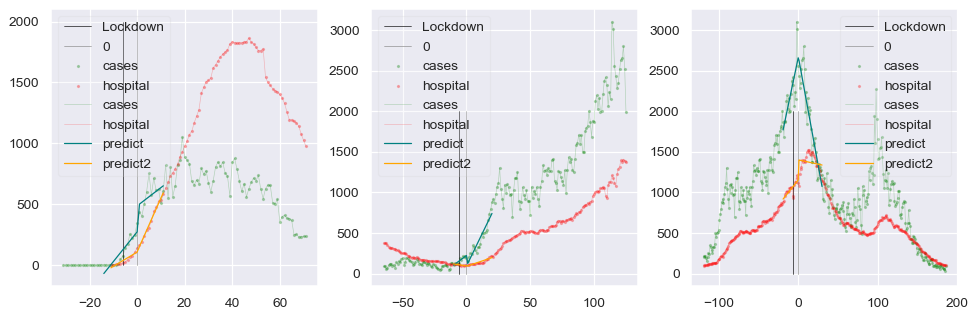

this is 6


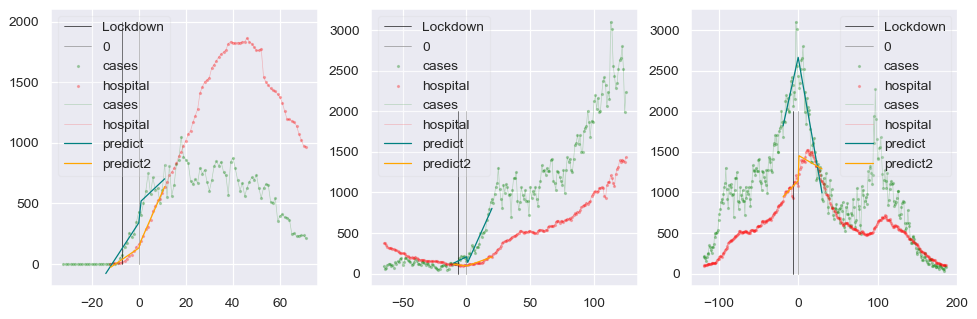

this is 7


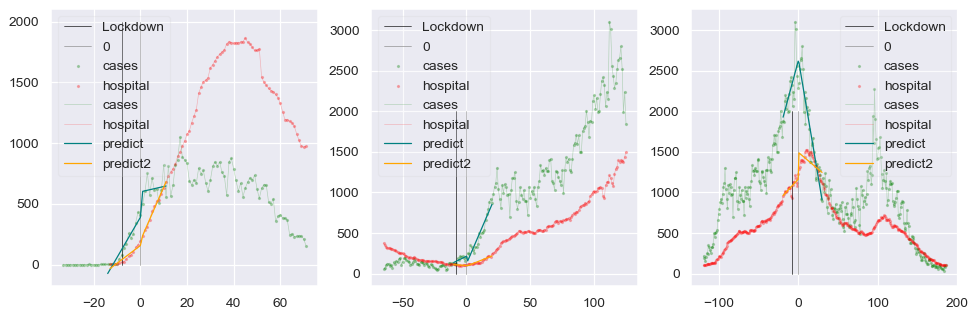

this is 8


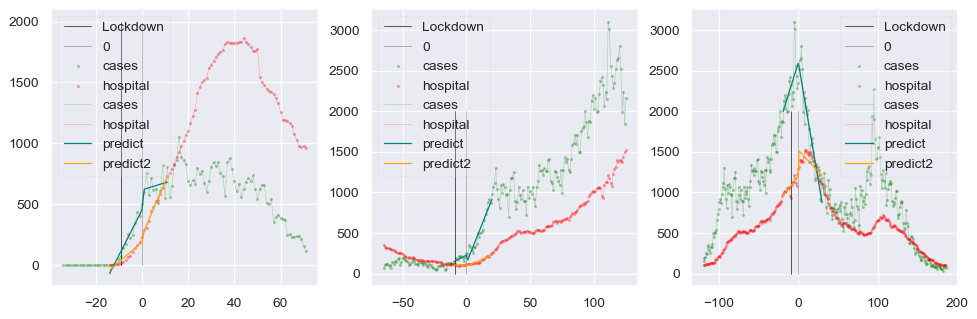

this is 9


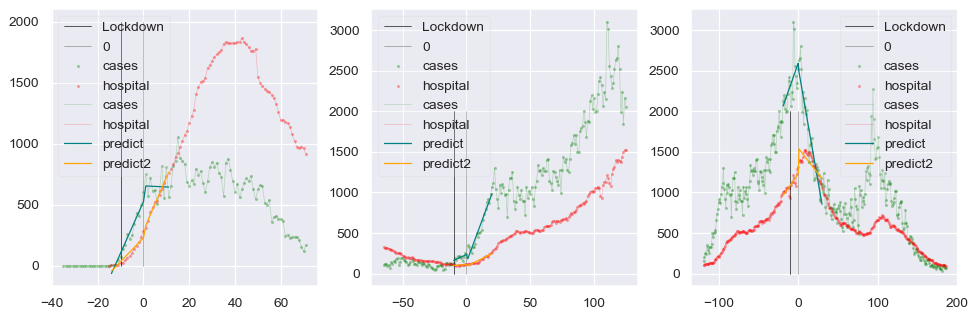

this is 10


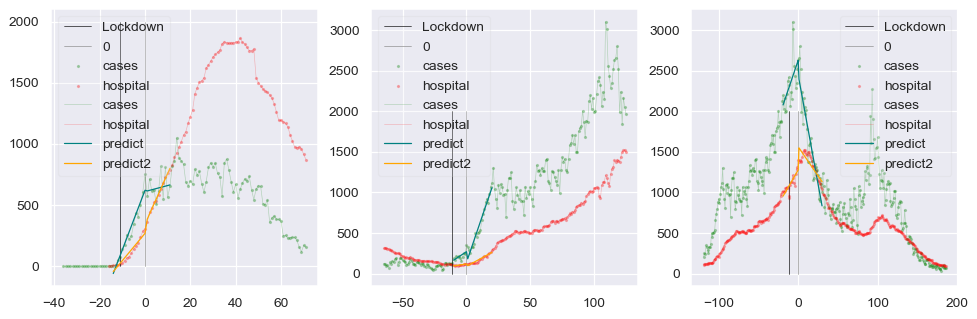

this is 11


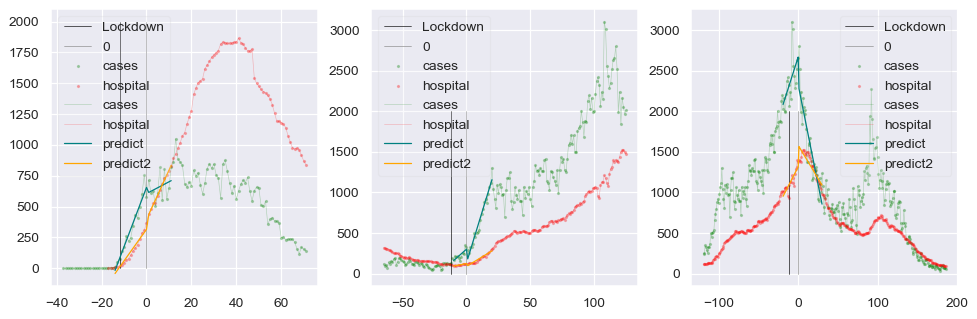

this is 12


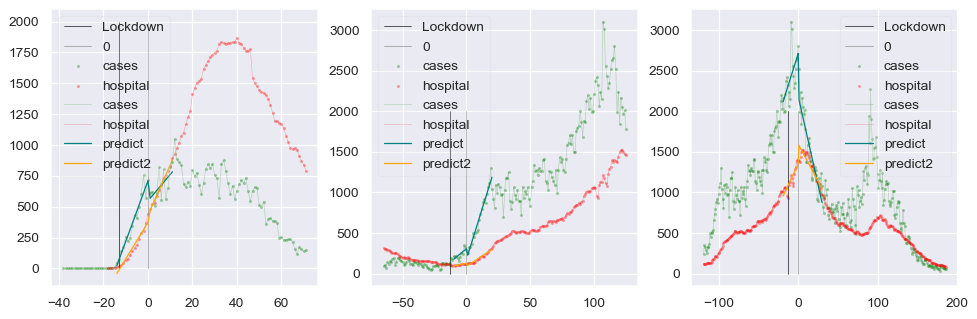

this is 13


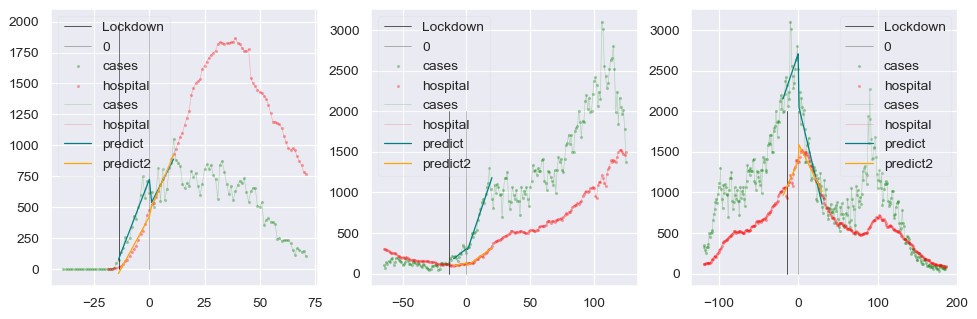

this is 14


In [2]:
# os.getcwd()

#    - COVID CASES -
df_cov = pd.read_csv('data/graph_1-1_page_par_region.csv')
df_cov

#    - HOSPITALIZATIONS -
df_hosp = pd.read_csv('data/graph_3-1_page_par_region.csv')
#df_hosp

#    - DEATH -
df_death = pd.read_csv('https://msss.gouv.qc.ca/professionnels/statistiques/documents/covid19/COVID19_Qc_RapportINSPQ_HistoVigie.csv')
#df_death = pd.read_csv('https://msss.gouv.qc.ca/professionnels/statistiques/documents/covid19/COVID19_Qc_RapportINSPQ_VigieCategories.csv')
#df_death = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')

df_cov.rename({
    'Date de résultat du test':'Date',
    'Cas confirmés':'Cases',
}, axis=1, inplace=True)

df_cov['Date'] = pd.to_datetime(df_cov['Date'])

df_hosp.rename({
    "Date d'admission":'Date',
    'Hors soins intensifs':'Not Intensive',
    'Aux soins intensifs':'Intensive',
}, axis=1, inplace=True)
df_hosp['Cases'] = df_hosp['Not Intensive'] + df_hosp['Intensive']

df_hosp['Date'] = pd.to_datetime(df_hosp['Date'])


from datetime import datetime

class ts:  # we'll use this for time calculations
    def fromdate(x): return datetime.timestamp(x)/60/60/24
    def days(x): return x

dates = [
    [
        datetime.strptime('2020-03-05','%Y-%m-%d'),  # when we start fitting the data
        datetime.strptime('2020-03-20','%Y-%m-%d'),  # lockdown
        datetime.strptime('2020-04-01','%Y-%m-%d'),  # when we stop fitting the data
    ],
    [
        datetime.strptime('2020-08-20','%Y-%m-%d'),
        datetime.strptime('2020-08-31','%Y-%m-%d'),
        datetime.strptime('2020-09-21','%Y-%m-%d'),
    ],
    [
        datetime.strptime('2020-12-05','%Y-%m-%d'),
        datetime.strptime('2020-12-25','%Y-%m-%d'),
        datetime.strptime('2021-01-25','%Y-%m-%d'),
    ],
]

# convert all dates to days
ts.dates = [
    [ts.fromdate(i) for i in x] for x in dates
]

# offset in days, not implemented yet,
# we'll have to take into consideration the incubation time
# and time for data collection so our models are more accurate
# but we can change it for each event we're looking at
offsets = [
    6,  # offset (in days) after lockdown for the change to affect the data
    10,
    12,
]

# convert columns to days (days since 1970, we'll subtract from it later to place it near zero)
df_hosp['Date'] = df_hosp['Date'].map(ts.fromdate)
df_cov['Date'] = df_cov['Date'].map(ts.fromdate)

df_hosp = df_hosp.dropna()

offset = 8

# if 1:  # uncomment if we remove the for loop
for offset in range(0, 15, 1):

    offset_time = ts.days(offset)  # incubation time

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (13,4), dpi = 90)
    axes=[ax1, ax2, ax3]

    for i in range(len(axes)):
        ax = axes[i]

#         offset=offsets[i] # add later!

        lockdown = ts.dates[i][1]
        before = ts.dates[i][0] - lockdown  # these are offsets
        after = ts.dates[i][2] - lockdown  # these are offsets
        
        # --------------------------------------------
        
        df_cov2 = df_cov.copy()  # model fitting
        df_hosp2 = df_hosp.copy()  # model fitting
        
        df_cov2['Date'] -= lockdown + offset_time  
        # moving code if you look at the dates they were all around 1677164178 or something
        #Because they were in seconds since 1970
        #I'm moving them to around zero
        # 0 is not lockdown, 0 is lockdown + incubation time, etc
        
        df_cov2 = df_cov2.loc[df_cov2['Date'] < after]  # remove before max date
        df_cov2 = df_cov2.loc[df_cov2['Date'] > before]  # remove after min date
       
        df_hosp2['Date'] -= lockdown + offset_time
        df_hosp2 = df_hosp2.loc[df_hosp2['Date'] < after]
        df_hosp2 = df_hosp2.loc[df_hosp2['Date'] > before]

        df_cov2['Lockdown'] = (df_cov2['Date'] > 0).astype(int)
        df_hosp2['Lockdown'] = (df_hosp2['Date'] > 0).astype(int)

        # --------------------------------------------
        
        df_cov3 = df_cov.copy()  # display
        df_hosp3 = df_hosp.copy()  # display
        
        display_size = 6
        
        df_cov3['Date'] -= lockdown + offset_time
        df_cov3 = df_cov3.loc[df_cov3['Date'] < after*display_size]  # display_size times more data
        df_cov3 = df_cov3.loc[df_cov3['Date'] > before*display_size]
        df_hosp3['Date'] -= lockdown + offset_time
        df_hosp3 = df_hosp3.loc[df_hosp3['Date'] < after*display_size]
        df_hosp3 = df_hosp3.loc[df_hosp3['Date'] > before*display_size]

        # --------------------------------------------
        
        real_lockdown=-offset_time  # we'll draw a line when the real lockdown happened
        ax.plot([real_lockdown, real_lockdown], [0, 2000], c='#000', alpha=1.0, linewidth=0.5, label='Lockdown')
        ax.plot([0, 0], [0, 2000], c='#888', alpha=1.0, linewidth=0.5, label='0')

        # --------------------------------------------
        
        # both scatter and plot
        linewidth=0.5
        ax.scatter(df_cov3['Date'], df_cov3['Cases'], c='green', alpha=0.25, s=2.5, label='cases')
        ax.scatter(df_hosp3['Date'], df_hosp3['Cases'], c='red', alpha=0.25, s=2.5, label='hospital')
        ax.plot(df_cov3['Date'], df_cov3['Cases'], c='green', alpha=0.25, linewidth=linewidth, label='cases')
        ax.plot(df_hosp3['Date'], df_hosp3['Cases'], c='red', alpha=0.25, linewidth=linewidth, label='hospital')

        # --------------------------------------------
        
        formula='''Cases ~ 
            Date
            + Lockdown
            + Date*Lockdown
        '''
        
        #formula='''Cases ~  Date*Lockdown + Date + Lockdown 
        #            y    =  const    +      b1x +  b2c
        #Const is the intercept, b1x is date, b2c is lockdown
        
#         model1=ols(formula,data=df_cov2).fit()
#         model2=ols(formula,data=df_hosp2).fit()
#         ax.plot(df_hosp2['Date'],model2.predict(df_cov2),c='orange',alpha=1.0,linewidth=1.0,label='predict2')
#         ax.plot(df_hosp2['Date'],model2.predict(df_cov2),c='orange',alpha=1.0,linewidth=1.0,label='predict2')

        y, x = dmatrices(formula, df_cov2, return_type='dataframe')
        model1 = sm.OLS(y, x).fit()
        ax.plot(df_cov2['Date'], model1.predict(x), c='teal', alpha=1.0, linewidth=1.0, label='predict')
        y, x = dmatrices(formula, df_hosp2, return_type='dataframe')
        model2 = sm.OLS(y, x).fit()
        ax.plot(df_hosp2['Date'], model2.predict(x), c='orange', alpha=1.0, linewidth=1.0, label='predict2')

        ax.legend(fancybox=True, framealpha=0.2)

    plt.show()
    print(f'this is {offset}')

In [3]:
# df_cov['Date']-ts.dates[0]
# df_cov
# df_cov = pd.read_csv('data/graph_1-1_page_par_region.csv')
# df_cov.loc[df_cov['Cas confirmés']>0]
# df_cov2

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     119.6
Date:                Thu, 23 Feb 2023   Prob (F-statistic):           9.75e-22
Time:                        10:31:22   Log-Likelihood:                -336.29
No. Observations:                  50   AIC:                             680.6
Df Residuals:                      46   BIC:                             688.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2707.2143     90.630     29.871      0.000    2524.785    2889.644
Date             28.9962      8.155      3.556      0.001      12.580      45.412
Lockdown       -619.0212    120.067     -5.156      0.000    -860.703    -377.340
Date:Lockdown   -70.0603      9.284     -7.547      0.000     -88.748     -51.373
==============================================================================
Omnibus:                       12.560   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.243
Skew:                           0.951   Prob(JB):                     0.000807
Kurtosis:                       4.793   Cond. No.                         96.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# model.summary()
# ts.days

In [ ]:
# y,x=dmatrices('Cases ~ Date',df_cov)

# model=sm.OLS(y,x).fit()
# model.summary()


In [ ]:
#df.columns


## 1- COVID CASES

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


In [ ]:
x_cov =[['','',]]
y_cov =[['']]

#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020 

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4)  paragraph explanation of your findings for that event.

### 2- HOSPITALIZATIONS

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4) paragraph explanation of your findings for that event.

### 3- DEATHS

#### A- Dependances and Response definition

In [ ]:
# if a common df is used, use: df.copy()


#### B- RDD for D1. 20/3/2020 | D2. 31/8/2020 | D3. 25/12/2020

#### C.1) PLOT

#### C.2) Interpretation of the p-value on the effect of the measure taken

#### C.3) Justification on the design of your regression

#### C.4)  paragraph explanation of your findings for that event.

# - CONCLUSION -
### A 2 paragraph explanation of your findings for that event.